In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [101]:
df = pd.read_csv("../../../data/class_credit_score_mvi_simple_strategy.csv", index_col="ID")
print(df.shape)
df = df.dropna(subset=['Credit_Score'])
print(df.shape)

(100000, 37)
(100000, 37)


In [102]:
def handle_outliers(data: pd.DataFrame, strategy: str):
    data = data.copy(deep=True)
    summary = data.describe()
    for var in data.columns:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=False, threshold=3.0)

        if strategy == "drop":
            data = data[(data[var] >= bottom) & (data[var] <= top)]
        elif strategy == "replace_median":
            non_outliers = data[(data[var] >= bottom) & (data[var] <= top)]
            median = non_outliers[var].median()
            data[var] = data[var].apply(
                lambda x: median if x > top or x < bottom else x
            )
        elif strategy == "truncate":
            data[var] = data[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        else:
            raise ValueError("Not Implemented")

    return data


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import dslabs_functions as dslabs
import seaborn as sns

In [105]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, auc, f1

In [106]:
def generate_eval_chart(df, clf):
    target = "Credit_Score"
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    print(f"Train#={len(X_train)} Test#={len(X_test)}")
    print(f"Labels={pd.unique(y_train)}")
    print(X_train.shape, y_train.shape)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf.fit(X_train_scaled, y_train)
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)

    metrics_train = calculate_metrics(y_train, y_train_pred)
    metrics_test = calculate_metrics(y_test, y_test_pred)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1-Score'],
        'Training': metrics_train,
        'Test': metrics_test
    })
    metrics_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    sns.barplot(ax=axs[0], x='Metric', y='Score', hue='Set', data=metrics_melted)
    axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
    axs[0].bar_label(axs[0].containers[1], fmt="%.2f")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, ax=axs[1], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    return fig, axs

Train#=34291 Test#=8573
Labels=[1. 0.]
(34291, 36) (34291,)


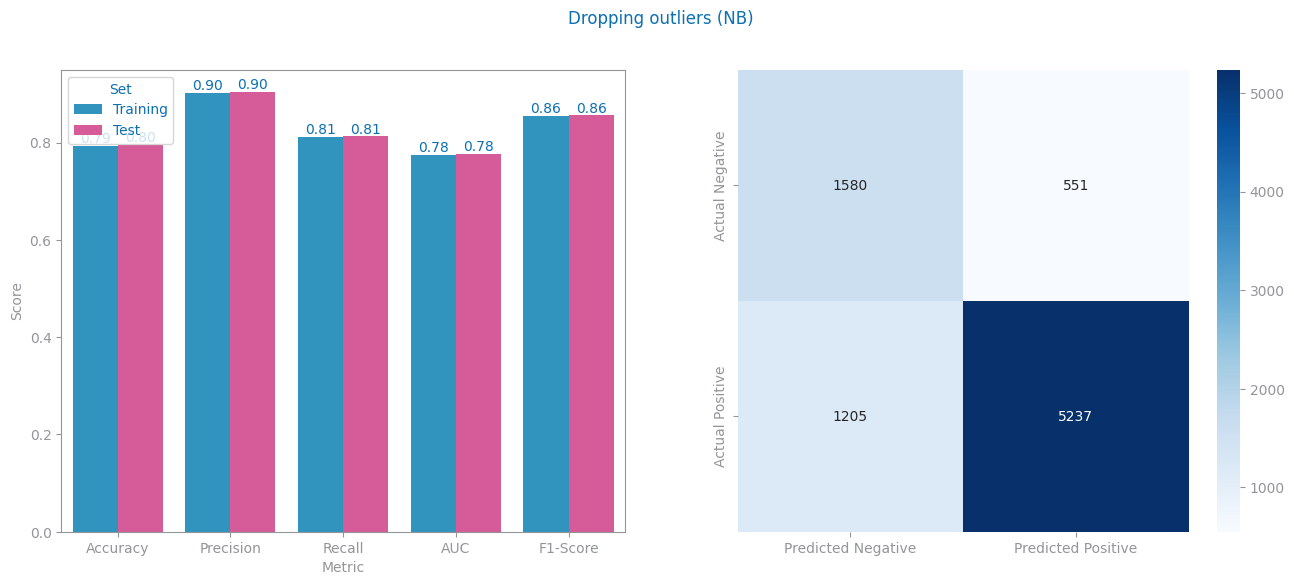

In [107]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="drop"), GaussianNB())
fig.suptitle("Dropping outliers (NB)")
plt.savefig(f"images/service_dropping_outliers_nb.png")

Train#=80000 Test#=20000
Labels=[1. 0.]
(80000, 36) (80000,)


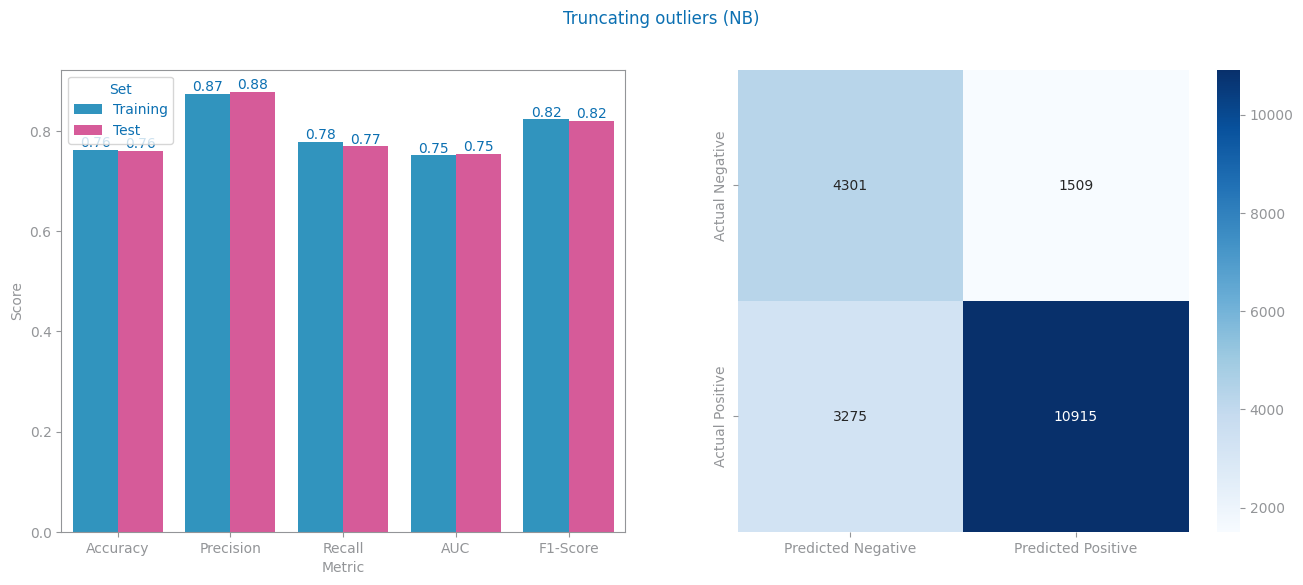

In [108]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="truncate"), GaussianNB())
fig.suptitle("Truncating outliers (NB)")
plt.savefig(f"images/service_truncating_outliers_nb.png")

Train#=34291 Test#=8573
Labels=[1. 0.]
(34291, 36) (34291,)


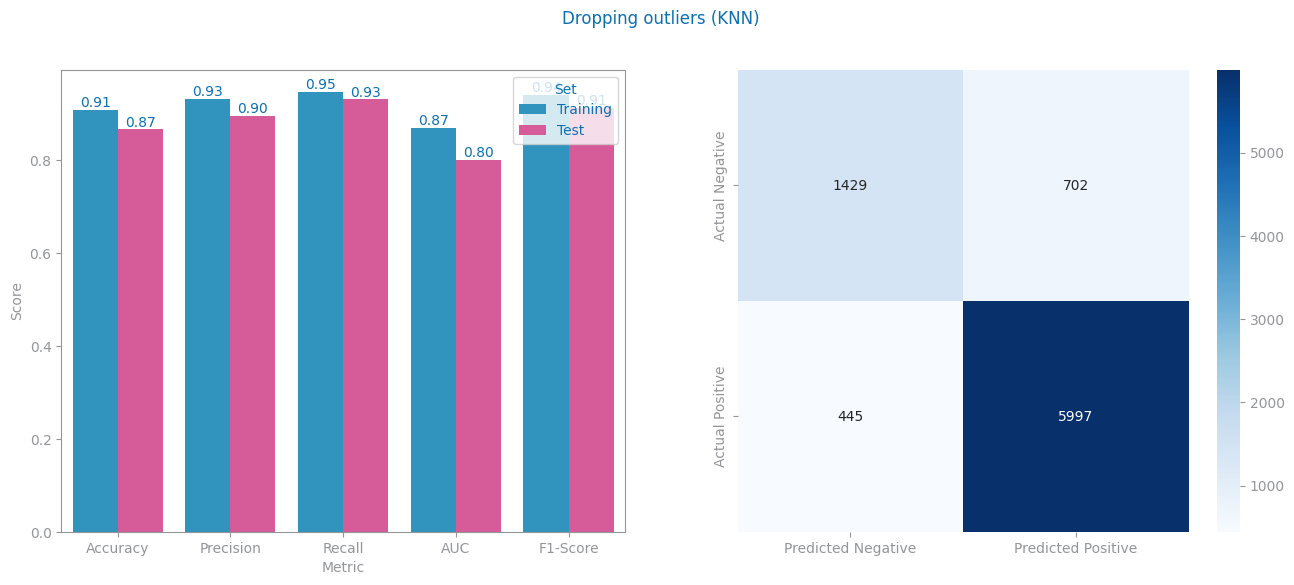

In [109]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="drop"), KNeighborsClassifier())
fig.suptitle("Dropping outliers (KNN)")
plt.savefig(f"images/service_dropping_outliers_knn.png")

Train#=80000 Test#=20000
Labels=[1. 0.]
(80000, 36) (80000,)


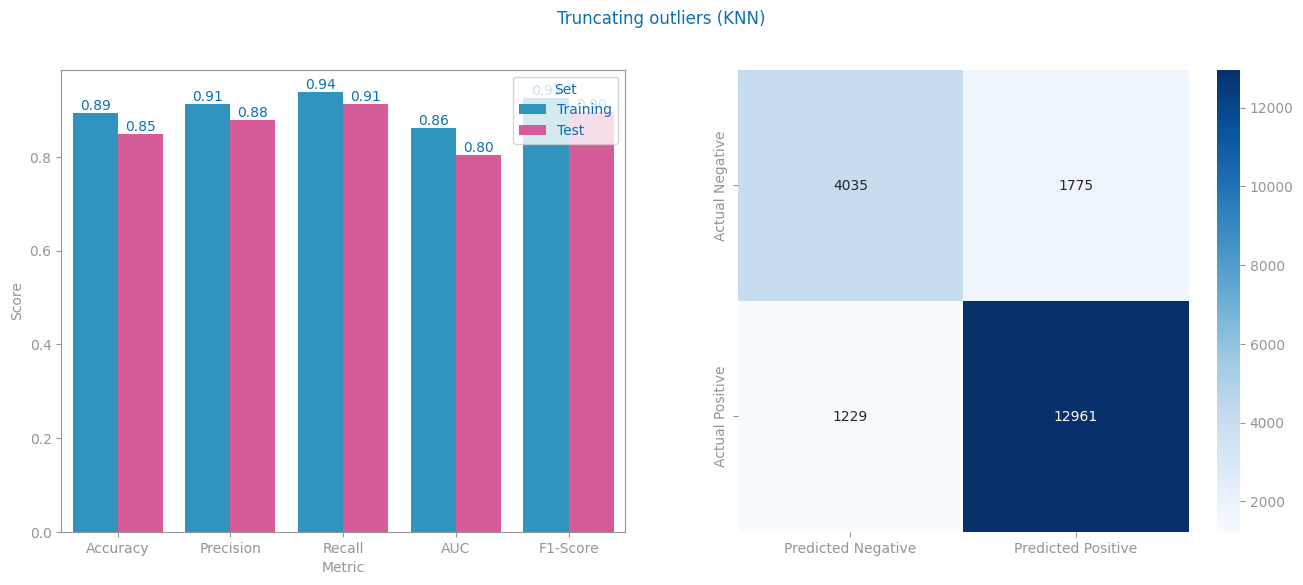

In [110]:
fig, axs = generate_eval_chart(handle_outliers(df, strategy="truncate"), KNeighborsClassifier())
fig.suptitle("Truncating outliers (KNN)")
plt.savefig(f"images/service_truncating_outliers_knn.png")

In [111]:
df_dropped = handle_outliers(df, strategy="drop")
print(df_dropped.shape)
print(df_dropped.columns)
df_dropped.to_csv("../../../data/class_credit_score_outliers_removed.csv")

(42864, 37)
Index(['Customer_ID', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'NumofLoan', 'Delay_from_due_date',
       'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries',
       'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'TotalEMIpermonth',
       'Amountinvestedmonthly', 'MonthlyBalance', 'Credit_Score', 'sin_month',
       'cos_month', 'PaydayLoan', 'AutoLoan', 'Credit-BuilderLoan',
       'StudentLoan', 'NotSpecified', 'MortgageLoan', 'HomeEquityLoan',
       'DebtConsolidationLoan', 'PersonalLoan', 'spent', 'value_payments'],
      dtype='object')
